# Boosted Noise Reducer model training notebook

### Dependencies

In [50]:
import os
import cv2
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV
%matplotlib inline

In [51]:
import warnings
warnings.filterwarnings("ignore")

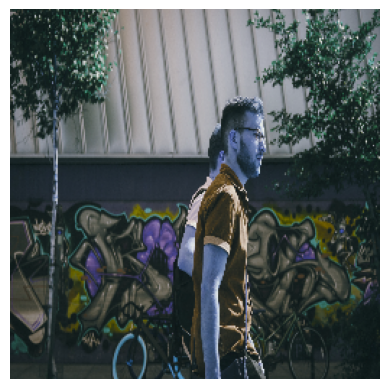

In [52]:
img = cv2.imread("0020.png")
img = cv2.resize(img,(256,256))

plt.imshow(img)
plt.axis(False)
plt.show()

### Creating Gausian Noise in images 

In [53]:
sigma = 25
mean = 0
x,y,z = img.shape

gauss = np.random.normal(mean,sigma,(x,y,z)).astype(np.uint8)
noisy = cv2.add(img, gauss)

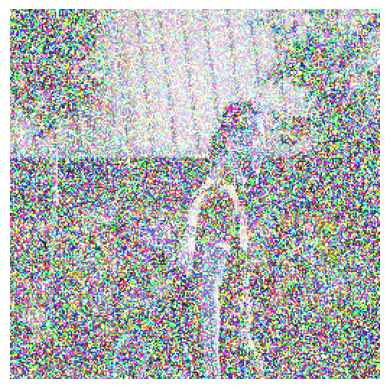

In [54]:
plt.imshow(noisy)
plt.axis(False)
plt.show()

In [60]:
def Gen_Gauss_Noise(image,noise_lvl = 25):
    x,y,z = image.shape
    mean = 0
    
    sigma = noise_lvl
    gauss = np.random.normal(mean,sigma,(x,y,z)).astype(np.uint8)
    noisy_img = cv2.add(image,gauss)
    
    return noisy_img

### Feature Collection

In [56]:
gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY)
mean_blur = cv2.blur(gray,(3,3))
median_blur = cv2.medianBlur(gray,ksize=3)
laplacian = cv2.Laplacian(gray,cv2.CV_64F,ksize=3)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)

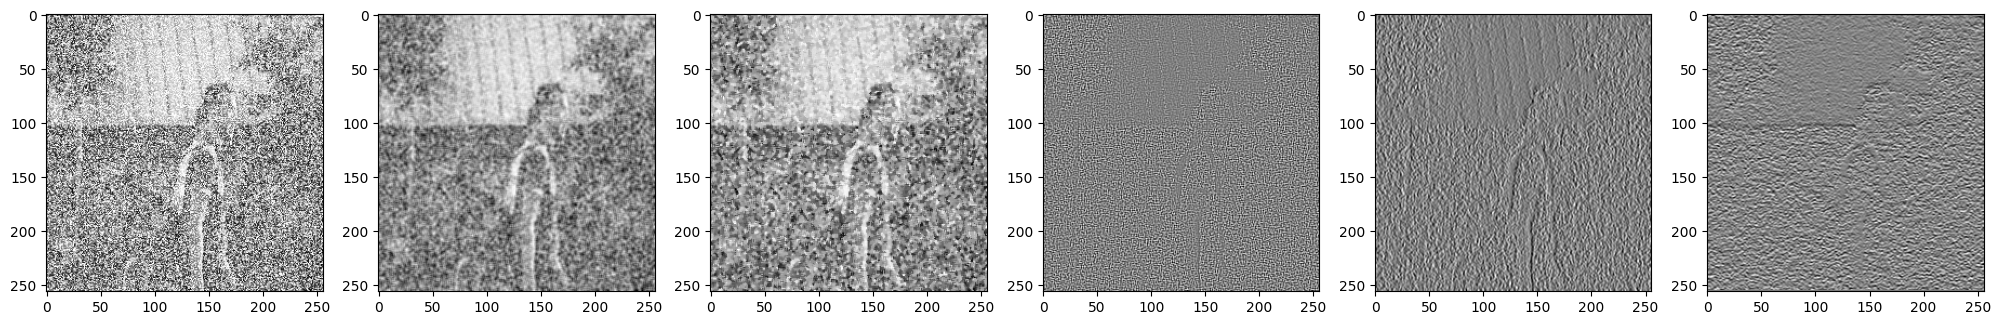

In [57]:
fig,ax = plt.subplots(ncols=6,figsize = (25,20))
ax[0].imshow(gray,cmap = "gray")
ax[1].imshow(mean_blur,cmap = "gray")
ax[2].imshow(median_blur,cmap = "gray")
ax[3].imshow(laplacian,cmap = "gray")
ax[4].imshow(sobelx,cmap = "gray")
ax[5].imshow(sobely,cmap = "gray")
plt.show()

In [58]:
def Feature_Collection(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    mean_blur = cv2.blur(gray,(3,3))
    median_blur = cv2.medianBlur(gray,ksize=3)
    laplacian = cv2.Laplacian(gray,cv2.CV_64F,ksize=3)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    feature_stack = np.stack([gray,mean_blur,median_blur,laplacian,sobelx,sobely])
    return feature_stack.reshape(-1, 6)

### Applying Preprocessing Functions to all images

In [61]:
folder = "Data/DIV2K_train_HR"
X = []
y = []
for i in os.listdir(folder):
    img_path = os.path.join(folder,i)
    if img_path is None:
        continue
    
    img = cv2.imread(img_path)
    img = cv2.resize(img,(256,256))
    clean_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    noisy_img = Gen_Gauss_Noise(img)
    print(f"[{i}] - noisy image generated")
    
    feature_stack = Feature_Collection(noisy_img)
    print(f"[{i}] - feature stack created")
    
    X.append(feature_stack)
    y.append(clean_gray.flatten())
    print(f"[{i}] - Data appended!")

    print("-------------")

[0001.png] - noisy image generated
[0001.png] - feature stack created
[0001.png] - Data appended!
-------------
[0002.png] - noisy image generated
[0002.png] - feature stack created
[0002.png] - Data appended!
-------------
[0003.png] - noisy image generated
[0003.png] - feature stack created
[0003.png] - Data appended!
-------------
[0004.png] - noisy image generated
[0004.png] - feature stack created
[0004.png] - Data appended!
-------------
[0005.png] - noisy image generated
[0005.png] - feature stack created
[0005.png] - Data appended!
-------------
[0006.png] - noisy image generated
[0006.png] - feature stack created
[0006.png] - Data appended!
-------------
[0007.png] - noisy image generated
[0007.png] - feature stack created
[0007.png] - Data appended!
-------------
[0008.png] - noisy image generated
[0008.png] - feature stack created
[0008.png] - Data appended!
-------------
[0009.png] - noisy image generated
[0009.png] - feature stack created
[0009.png] - Data appended!
------

### Spliting the Data

In [62]:
X = np.vstack(X)
y = np.hstack(y)
print(X.shape)
print(y.shape)

(52428800, 6)
(52428800,)


In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)
print(X_train.shape)
print(X_test.shape)

(41943040, 6)
(10485760, 6)


In [ ]:
est = xgb.XGBRegressor(objective="reg:squarederror",device = "gpu")

param_grid = {
    "n_estimators":[300,500,1000],
    "learning_rate": [0.01,0.1,0.2],
    "max_depth": [3,5,7],
    "subsample":[0.5,0.6,0.7],
    "colsample_bytree":[0.5,0.7,0.9],
    "lambda":[0,0.2,0.4],
    "alpha":[0,0.2,0.4]
    }

rsv = RandomizedSearchCV(est, param_grid,verbose=1)

rsv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='gpu',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'alpha': [0, 0.2, 0.4],
                                        'colsample_bytree': [0.5, 0.7, 0.9],
                                        'lambda': [0, 0.2, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.5, 0.6, 0.7]},
                   verbose=1)

In [16]:
model = rsv.best_estimator_
model.score(X_test,y_test)

0.07432210445404053